In [1]:
import json
import torch
import numpy as np
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import InterpolationMode

import sys
from pathlib import Path

notebook_path = Path().resolve()
project_root = notebook_path.parent
sys.path.append(str(project_root))

from utils import DiffusionModelPipeline, ImagePromptDataset

c:\Users\wolfg\OneDrive\Documents\Projects\OMI-Training-Pipeline\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize Model

Observations
- inC - needs to be .vae.config.latent_channels


In [2]:
dit_params = {
    'channels': 384,
    'nBlocks': 8,
    'nHeads': 16,
    'conditionC': 384,
    'patchSize': 1,
    'text_embed_dim': 256,
}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionModelPipeline(dit_params = dit_params,
                       emaStrength= 0.999,
                       device=device)

In [4]:
##Hacky work around - will fix later
model.tokenizer.name_or_path = 't5-base'
model.text_encoder.config.name_or_path = 't5-base'
model.vae.config._name_or_path = 'flux_schnell_vae'

In [5]:
print(f"total trainable parameters: {model.total_parameters}, in mil {model.total_parameters/1e6} in bil {model.total_parameters/1e9}") 

total trainable parameters: 75386432, in mil 75.386432 in bil 0.075386432


In [6]:
model

DiffusionModelPipeline ({
  "_class_name": "DiffusionModelPipeline",
  "_diffusers_version": "0.30.3",
  "_transformers_version": "4.45.1",
  "_pytorch_version": "2.4.1+cu124",
  "device": "cuda",
  "text_encoder": {
    "architecture": "T5EncoderModel",
    "name_or_path": "t5-base"
  },
  "tokenizer": {
    "name_or_path": "t5-base",
    "vocab_size": 32100,
    "max_length": "1.000000e+30"
  },
  "diffusion_model": {
    "Rectified Flow": "RectifiedFlow"
  },
  "control_transformer": {
    "ControlTransformer": "ControlTransformer"
  },
  "vae": {
    "class_name": "AutoencoderKL",
    "name_or_path": "flux_schnell_vae",
    "diffusers version": "0.30.0.dev0"
  }
})

## Test Gen Prompt Only

In [7]:
image = model('', num_inference_steps=50)

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\wolfg\OneDrive\Documents\Projects\OMI-Training-Pipeline\pipelines\dit-control-pipeline-experiments\utils\dit.py:105: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attnOutput = torch.nn.functional.scaled_dot_product_attention(q, k, v)
100%|██████████| 50/50 [00:00<00:00, 59.15it/s]


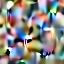

In [8]:
image[0]

In [9]:
np_img = np.array(image[0])
print(np_img.shape)

#image shape should be what we expect to output

(64, 64, 3)


## Test with control map

In [10]:
# dataset = load_dataset("openmodelinitiative/initial-test-dataset")
# dataset = load_dataset("laion/laion2B-en")
# data_id = "idning/ffhq64-caption"
# data_id = "idning/ffhq128-caption"
data_id= "pcuenq/lsun-bedrooms"

ds = load_dataset(data_id)

#to run on runpod I had to comment out lines 188/189 in usr/lib/local/pyhton/datasets/features/Image.py 

# ds = load_dataset("pcuenq/lsun-bedrooms")
split_ds = ds['train'].train_test_split(test_size=0.1, seed=42)


In [11]:
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=InterpolationMode.LANCZOS),
    transforms.ToTensor(),  # Converts to tensor and scales pixel values to [0, 1]
])

In [12]:
# Create the custom dataset
train_dataset = ImagePromptDataset(split_ds["train"], transform=transform, device = torch.device('cuda'), maps = ['depth','edge'])
val_dataset = ImagePromptDataset(split_ds["test"], transform=transform , device = torch.device('cuda'), maps = ['depth', 'edge'])   

Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
c:\Users\wolfg\OneDrive\Documents\Projects\OMI-Training-Pipeline\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\wolfg/.cache\torch\hub\intel-isl_MiDaS_master


In [13]:
sample = train_dataset[0]

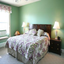

In [14]:
transforms.ToPILImage()(sample[0])

100%|██████████| 50/50 [00:00<00:00, 65.53it/s]


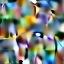

In [15]:
image_no_map = model('', num_inference_steps=50)
image_no_map[0]

100%|██████████| 50/50 [00:00<00:00, 73.48it/s]


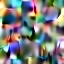

In [16]:
image_two_map = model([''], num_inference_steps=50, control_maps=sample[-1].unsqueeze(0))
image_two_map[0]

# Training

In [17]:
# Training DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=0  # Set to 0 if you encounter issues on Windows
)

# Validation DataLoader
val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

In [18]:
history = model.train(train_dataloader,
            val_dataloader,
            epochs = 3,
            log_interval= 1,
            save_interval= 1,
            output_dir= '../results/bedrooms',
            patience= 1000,
            visualize=True,
            visualize_interval= 1,
            visualize_prompt= [' ',
                               '',
                               '  ',
                               '   ',],
            num_inference_steps= 10)

changing optimizer to AdamW and added rectified flow 


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [ ]:
# Save history 
with open('../results/bedrooms/history.json', 'w') as f:
    json.dump(history, f)
